# COMP7015: Artificial Intelligence *(Semester 1, 2024/25)*

# Programming Assignment 2 Sample Solution

**Instructions:**
1. Fill in your name and student id in the following cell.
2. Write all you codes in this jupyter notebook.
3. You can define your own functions, methods, classes, and variables as you need.
4. Please name your functions and variables in a clear and concise way to maximize the redability of your codes.
5. Name your jupyter notebook in the format of `pa2_<student id>.ipynb` and submit it in Moodle. For example, `pa2_16483715.ipynb`.
6. What you write in this notebook must be your own input. Copying from others and online resources are subject to heavy penalty. Lending and borrowing assignment solutions are both regarded as dishonest behaviours and are subject to heavy penalty and disciplinary actions.

In [1]:
# Fill in your name and student ID
name = ''
student_id = ''

# Q1. Handwritten letter recognition with MLP (50 marks)

In this task, you are required to define and train an MLP model for the handwritten letter recognition task. We use the `EMNIST` dataset. See [[its Readme file]](https://www.westernsydney.edu.au/__data/assets/text_file/0019/1204408/EMNIST_Readme.txt) for a detailed description. We provide you with the following code block to load the dataset.

In this dataset, there are 124,800 images for training and 20,800 images for testing. Each image corresponds to one of the 26 English letters.

In [2]:
import torch

import torchvision
from torchvision import transforms
from torchvision.datasets import EMNIST

from matplotlib import pyplot as plt

In [ ]:
# Some transformation are needed.
emnist_transform = transforms.Compose([
    lambda img: transforms.functional.rotate(img, -90),  # rotates the image by 90 degree
    lambda img: transforms.functional.hflip(img),  # flip the image horizontally
    transforms.ToTensor()
])

# The dataset can be loaded using the Pytorch function as below
emnist_train = EMNIST('./', train=True, download=True, split='letters',
                      transform=emnist_transform,
                      target_transform=lambda x: x-1)
emnist_test = EMNIST('./', train=False, download=True, split='letters',
                     transform=emnist_transform,
                     target_transform=lambda x: x-1)

A visualization of the dataset can be done as follows. It gives you an intuition about the dataset we are working with.

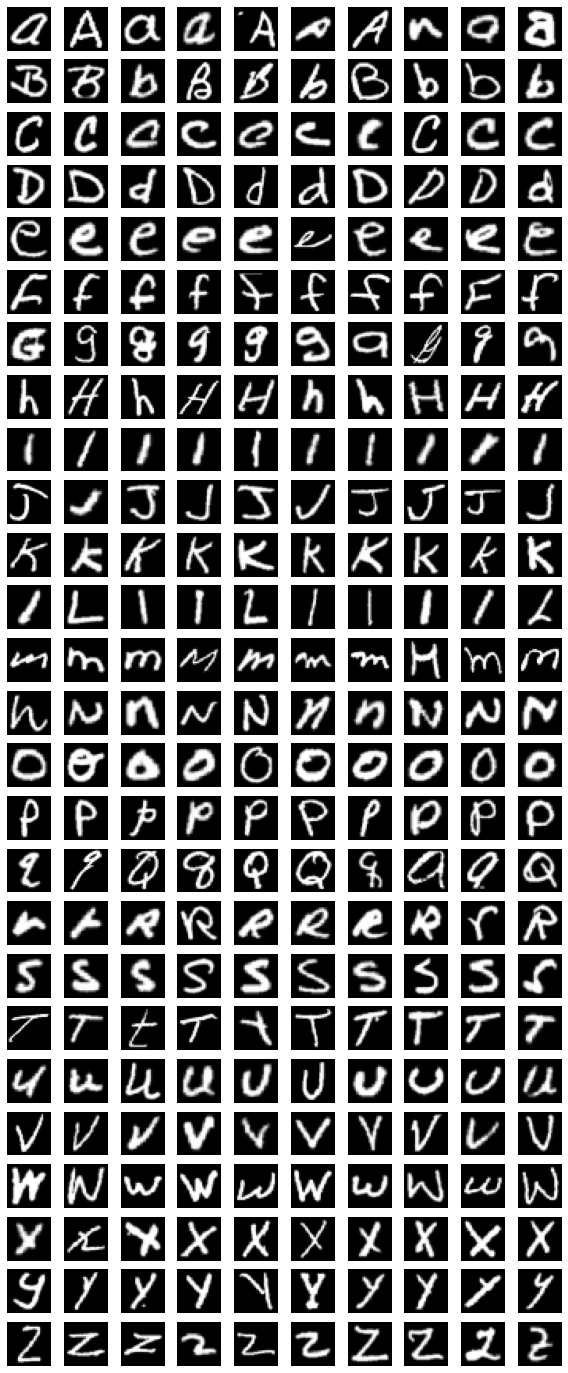

In [4]:
_, labels = zip(*emnist_train)
indices = [[i for i in range(len(labels)) if labels[i]==c] for c in range(26)]

fig, ax = plt.subplots(26, 10, figsize=(10, 25))
for c in range(26):
    for i in range(10):
        ax[c][i].imshow(emnist_train[indices[c][i]][0][0].numpy(), cmap='gray')
        ax[c][i].axis('off')
plt.show()

## (a) Define an MLP model to recognize the handwritten letters. Use three hidden layers for this MLP and the hidden sizes of the three hidden layers are 256, 512, and 512, respectively. Use ReLU as the activation function. (15 marks)

In [5]:
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, 256)
        self.linear2 = torch.nn.Linear(256, 512)
        self.linear3 = torch.nn.Linear(512, 512)
        self.linear4 = torch.nn.Linear(512, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        output = self.linear4(x)
        return output


## (b) Train an MLP model to recognize the handwritten letters. The following aspects should be covered in your answers.
1. The full pipeline of training such a model. (15 marks)
2. Sample some data from the training set as validation set. Monitor the accuracy over validation set during training and do early stopping based on the validation accuracy. (10 marks)
2. Compute the accuracy for the test set. (10 marks)

In [7]:
import time
from copy import deepcopy

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
mlp = MLP(28*28, 26)
mlp.to(device)

# get validation set
train_size = int(0.7*len(emnist_train))
test_size = len(emnist_train) - train_size
train_set, val_set = torch.utils.data.random_split(emnist_train, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)
test_loader = torch.utils.data.DataLoader(emnist_test, batch_size=256, shuffle=False)

optimizer = torch.optim.Adam(mlp.parameters(),
                             lr=0.01,
                             weight_decay=0.0001)

criterion = torch.nn.CrossEntropyLoss()


num_epochs = 10
since = time.time()
best_acc = 0
best_model_wts = deepcopy(mlp.state_dict())

for epoch in range(num_epochs):
    tic = time.time()
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 15)

    mlp.train()  # set to training mode
    running_loss_train = 0
    running_corrects_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # reset gradient of parameters to be optimzied

        output = mlp(inputs)  # forward pass: generate prediction
        loss = criterion(output, labels)  # forward pass: compute loss
        loss.backward()  # backward pass: compute gradients
        optimizer.step()  # update parameters

        preds = output.argmax(dim=1)
        running_loss_train += loss.item() * inputs.size(0)
        running_corrects_train += (preds == labels).sum().item()

    mlp.eval()
    running_loss = 0
    running_corrects = 0

    # computing gradient is not necessary in the validation phase.
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # get prediction and compute loss
            outputs = mlp(inputs)
            loss = criterion(outputs, labels)

            # get the predicted class indices
            _, preds = torch.max(outputs, 1)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    # The evaluation phase in this epoch is done. Compute the statistics.
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    epoch_acc_train = running_corrects_train / len(train_loader.dataset)
    print('Training Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    print('Time: {:.1f}s'.format(time.time()-tic))

    # check if the performance improves, copy the model if yes.
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = deepcopy(mlp.state_dict())
    print('='*15)
    print()

time_elapsed = time.time() - since
print('MLP training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))

# load the best model weights: early stopping
mlp.load_state_dict(best_model_wts)

# evaluate performance using the test set
mlp.eval()
running_loss = 0
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # get prediction and compute loss
        outputs = mlp(inputs)
        loss = criterion(outputs, labels)

        # get the predicted class indices
        _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    print('\nTest Loss: {:.4f} Acc: {:.4f}'.format(test_loss, test_acc))

Epoch 1/10
---------------
Training Loss: 0.9619 Acc: 0.7051
Validation Loss: 0.7303 Acc: 0.7765
Time: 22.2s

Epoch 2/10
---------------
Training Loss: 0.6627 Acc: 0.7992
Validation Loss: 0.6554 Acc: 0.8020
Time: 19.1s

Epoch 3/10
---------------
Training Loss: 0.6260 Acc: 0.8094
Validation Loss: 0.6396 Acc: 0.8047
Time: 16.9s

Epoch 4/10
---------------
Training Loss: 0.5973 Acc: 0.8199
Validation Loss: 0.6281 Acc: 0.8113
Time: 16.7s

Epoch 5/10
---------------
Training Loss: 0.5859 Acc: 0.8235
Validation Loss: 0.6207 Acc: 0.8079
Time: 16.5s

Epoch 6/10
---------------
Training Loss: 0.5702 Acc: 0.8272
Validation Loss: 0.5974 Acc: 0.8170
Time: 16.7s

Epoch 7/10
---------------
Training Loss: 0.5525 Acc: 0.8321
Validation Loss: 0.5514 Acc: 0.8342
Time: 16.8s

Epoch 8/10
---------------
Training Loss: 0.5392 Acc: 0.8370
Validation Loss: 0.5635 Acc: 0.8283
Time: 16.6s

Epoch 9/10
---------------
Training Loss: 0.5401 Acc: 0.8353
Validation Loss: 0.5751 Acc: 0.8268
Time: 16.5s

Epoch 10/1

# Q2. Basics of Convolutional Neural Network (30 marks)

## (a) Complete the function below to compute the convolution given an `input_tensor` (a two-dimensional tensor), a `kernel_tensor` and a `stride_size`. For simplicity, we only consider gray scale images. The function should return the output after doing convolution. The followings are expected. (20 marks)
1. The function correctly computes the convolution. (10 marks)
2. The function correctly handles different stride sizes. (5 marks)
3. The function output has the the same size as the input by using padding. (5 marks) 

**Hint**: the padding size can be computed using the equation given in lectures that computes the output size of the convolution.

In [24]:
import math

In [ ]:
def convolution(input_tensor, kernel_tensor, stride_size):
    # fill in your codes
    h, w = input_tensor.shape
    kh, kw = kernel_tensor.shape

    # padding size
    ph = math.ceil(((h-1) * stride_size + kh - h)/2)
    pw = math.ceil(((w-1) * stride_size + kw - w)/2)

    input_padded = torch.zeros(h+2*ph, w+2*pw)
    input_padded[ph:-ph, pw:-pw] = input_tensor

    output = torch.zeros(h, w)
    for i in range(0, h):
        for j in range(0, w):
            start_i = i*stride_size
            start_j = j*stride_size
            output[i, j] = (input_padded[start_i:start_i+kh, start_j:start_j+kw] * kernel_tensor).sum()

    return output

##### The following code blocks are examples of calling this function. Do NOT modify them.

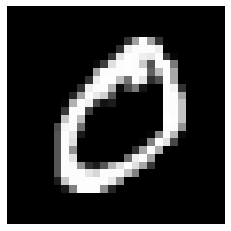

In [56]:
# load in an image
img = torch.load('./img.pt')
plt.imshow(img.numpy(), cmap='gray')
plt.axis('off')

# define a kernel
kernel = torch.FloatTensor([
    [-1, -1, -1],
    [1, 1, 1],
    [0, 0, 0]
])

(-0.5, 27.5, 27.5, -0.5)

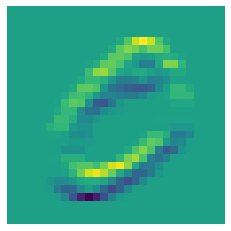

In [57]:
# An example of calling your function
output = convolution(img, kernel, stride_size=1)

# Your output should be visualized if your function is working as desired.
plt.imshow(output.numpy())
plt.axis('off')

(-0.5, 27.5, 27.5, -0.5)

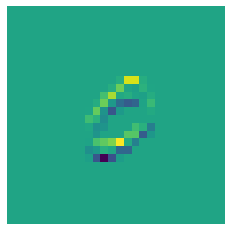

In [58]:
# Another example
output = convolution(img, kernel, stride_size=2)

# Your output should be visualized if your function is working as desired.
plt.imshow(output.numpy())
plt.axis('off')

## (b) Complete the function below to do the max pooling given `input tensor` (a two-dimensional tensor), a `kernel_size` and a `stride_size`.  (10 marks)

In [ ]:
def max_pooling(input_tensor, kernel_size, stride_size):
    # fill in your codes
    h, w = input_tensor.shape

    output = torch.zeros(int(h/2), int(w/2))
    for i in range(0, int(h/2)):
        for j in range(0, int(w/2)):
            output[i, j] = (input_tensor[2*i:2*i+kernel_size, 2*j:2*j+kernel_size]).max()

    return output

##### The following code block is an example of calling this function. Do NOT modify it.

(-0.5, 13.5, 13.5, -0.5)

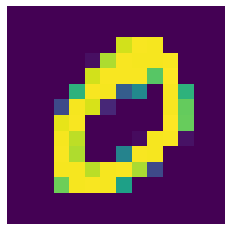

In [60]:
output_pooling = max_pooling(img, kernel_size=2, stride_size=2)

plt.imshow(output_pooling.numpy())
plt.axis('off')

# Q3. Using Pretrained CV Models (20 marks)

In this question, we use a pretrained CV model and fine-tune it for a classification task. We use the ResNet model. Here is a detailed insruction about how to use it: https://pytorch.org/hub/pytorch_vision_resnet/.

The `torch.hub` module is a newer way to import and use pretrained models. The procedures of fine-tune it are the same as introduced in the lab session.

In [61]:
# The pretrained model can be loaded by the following line and the corresponding data transform is given.

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

resnet_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [63]:
# this shows you the architecture of the ResNet model.
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**Hint**: As shown above, the last layer for classification in ResNet18 model is called `fc`.

## (a) Fine-tune the ResNet model for the handwritten letter recognition dataset (EMNIST) we used in Q1.  The followings are expected. (15 marks)

1. Build the full pipeline of fine-tuning the pretrained ResNet model. (5 marks)
2. Sample some data from the training set as validation set. Monitor the accuracy over validation set during training and do early stopping based on the validation accuracy. (5 marks)
2. Compute the accuracy for the test set. (5 marks)

In [66]:
for param in model.parameters():
    param.requires_grad = False
model.fc = torch.nn.Linear(512, 26)

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    lambda x: x.repeat(3, 1, 1),  # copy to three channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

emnist_train = EMNIST('./', train=True, download=True, split='letters',
                      transform=transform,
                      target_transform=lambda x: x-1)
emnist_test = EMNIST('./', train=False, download=True, split='letters',
                     transform=transform,
                     target_transform=lambda x: x-1)

# get validation set
train_size = int(0.7*len(emnist_train))
test_size = len(emnist_train) - train_size
train_set, val_set = torch.utils.data.random_split(emnist_train, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False)
test_loader = torch.utils.data.DataLoader(emnist_test, batch_size=256, shuffle=False)


params = []
for name, x in model.named_parameters():
    if x.requires_grad:
        params.append(x)

optimizer = torch.optim.Adam(params,
                             lr=0.01,
                             weight_decay=0.0001)

criterion = torch.nn.CrossEntropyLoss()


num_epochs = 10
since = time.time()
best_acc = 0
best_model_wts = deepcopy(model.state_dict())

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 15)

    model.train()  # set to training mode
    running_loss_train = 0
    running_corrects_train = 0
    for i, (inputs, labels) in enumerate(train_loader):
        tic_iter = time.time()
        inputs, labels = inputs.cuda(), labels.cuda()
#         inputs = inputs.repeat(3, 1, 1)
#         labels = labels - 1  # map [1, 26] labels to [0, 25]

        optimizer.zero_grad()  # reset gradient of parameters to be optimzied

        output = model(inputs)  # forward pass: generate prediction
        loss = criterion(output, labels)  # forward pass: compute loss
        loss.backward()  # backward pass: compute gradients
        optimizer.step()  # update parameters

        preds = output.argmax(dim=1)
        running_loss_train += loss.item() * inputs.size(0)
        running_corrects_train += (preds == labels).sum().item()
        if i % 100 ==0:
            print(f'Iter {i+1}/{len(train_loader)}, Time: {time.time()-tic_iter:.3f}s')

    model.eval()
    running_loss = 0
    running_corrects = 0

    # computing gradient is not necessary in the validation phase.
    with torch.no_grad():
        for inputs, labels_ in val_loader:
            inputs, labels = inputs.cuda(), labels_.cuda()
#             inputs = inputs.repeat(3, 1, 1)
#             labels = labels_ - 1

            # get prediction and compute loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # get the predicted class indices
            _, preds = torch.max(outputs, 1)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    # The evaluation phase in this epoch is done. Compute the statistics.
    epoch_loss_train = running_loss_train / len(train_loader.dataset)
    epoch_acc_train = running_corrects_train / len(train_loader.dataset)
    print('Training Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss_train, epoch_acc_train))

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = running_corrects.double() / len(val_loader.dataset)
    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    print('Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    # check if the performance improves, copy the model if yes.
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = deepcopy(model.state_dict())
    print('='*15)
    print()

time_elapsed = time.time() - since
print('Finetuning complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best validation Acc: {:4f}'.format(best_acc))

# load the best model weights
model.load_state_dict(best_model_wts)

# evaluate performance using the test set
model.eval()
running_loss = 0
running_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # get prediction and compute loss
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # get the predicted class indices
        _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    print('\nTest Loss: {:.4f} Acc: {:.4f}'.format(test_loss, test_acc))

Epoch 1/10
---------------
Iter 1/683, Time: 0.145s
Iter 101/683, Time: 0.122s
Iter 201/683, Time: 0.123s
Iter 301/683, Time: 0.121s
Iter 401/683, Time: 0.122s
Iter 501/683, Time: 0.123s
Iter 601/683, Time: 0.122s
Training Loss: 0.8048 Acc: 0.7545
Validation Loss: 0.7957 Acc: 0.7623
Time: 3m 1s

Epoch 2/10
---------------
Iter 1/683, Time: 0.122s
Iter 101/683, Time: 0.121s
Iter 201/683, Time: 0.122s
Iter 301/683, Time: 0.122s
Iter 401/683, Time: 0.122s
Iter 501/683, Time: 0.122s
Iter 601/683, Time: 0.123s
Training Loss: 0.7088 Acc: 0.7866
Validation Loss: 0.6258 Acc: 0.8103
Time: 3m 1s

Epoch 3/10
---------------
Iter 1/683, Time: 0.122s
Iter 101/683, Time: 0.121s
Iter 201/683, Time: 0.123s
Iter 301/683, Time: 0.122s
Iter 401/683, Time: 0.121s
Iter 501/683, Time: 0.122s
Iter 601/683, Time: 0.122s
Training Loss: 0.6911 Acc: 0.7966
Validation Loss: 0.6205 Acc: 0.8127
Time: 3m 1s

Epoch 4/10
---------------
Iter 1/683, Time: 0.122s
Iter 101/683, Time: 0.123s
Iter 201/683, Time: 0.123s
Ite

## (b) Summarize the differences between the performance you obtain using the MLP and that obtained by the fine-tuned model. (5 marks)

The performance of fine-tuned model is worse than MLP in this senario. The reason is that the ResNet model is pretrained using color images but the target images are grayscale ones. This observation indicates that when the target data differs too much from the datasets used to pretrain the model, it might be better to train an even simpler model from scratch. Nevertheless, the accuracy obtained by MLP and fine-tuned model over the test set are close and we also observe that with each iteration in fine-tuning, the accuracy improves. So, the fine-tuning is helpful when training from scratch is not possible and when we would like to apply pretrained models.